In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [46]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text, and_

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [11]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)

In [12]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement 
Station = Base.classes.station 

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = latest_date[0]

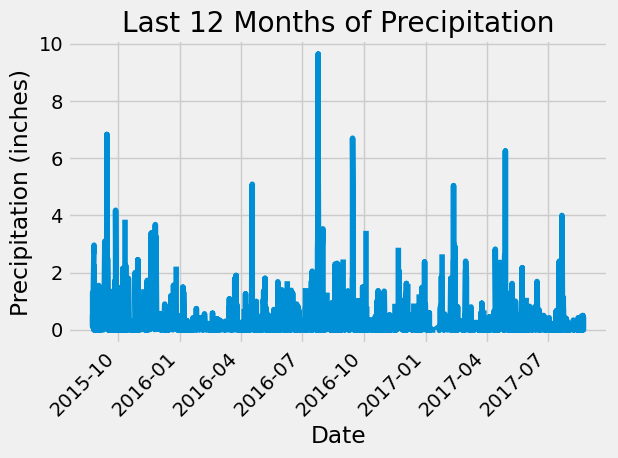

In [36]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
latest_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = pd.to_datetime(latest_date) - pd.DateOffset(days=365)

# Perform a query to retrieve the data and precipitation scores
# Modify the filter condition to check for a broader date range
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(text(f"date >= '{one_year_ago - pd.DateOffset(days=365)}'")).\
    order_by(Measurement.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
df['Date'] = pd.to_datetime(df['Date'])

# Sort the dataframe by date
df.sort_values(by='Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='Date', y='Precipitation', kind='line', title='Last 12 Months of Precipitation', legend=None)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df.describe()

print(summary_stats)

                                Date  Precipitation
count                           4559    4085.000000
mean   2016-08-15 03:42:02.921693184       0.201968
min              2015-08-25 00:00:00       0.000000
25%              2016-02-16 12:00:00       0.000000
50%              2016-08-15 00:00:00       0.020000
75%              2017-02-10 12:00:00       0.160000
max              2017-08-23 00:00:00       9.640000
std                              NaN       0.516756


# Exploratory Station Analysis

In [39]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Station.station)).scalar()
station_count

9

In [40]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Design a query to find the most active stations and their counts
most_active_stations = session.query(Measurement.station, func.count(Measurement.station).label('station_count'))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

# Print the results
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [43]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]

temperature_stats = session.query(func.min(Measurement.tobs).label('min_temperature'),
                                  func.max(Measurement.tobs).label('max_temperature'),
                                  func.avg(Measurement.tobs).label('avg_temperature'))\
                            .filter(Measurement.station == most_active_station_id)\
                            .first()

min_temperature, max_temperature, avg_temperature = temperature_stats
print(f"Most Active Station ID: {most_active_station_id}")
print(f"Lowest Temperature: {min_temperature}")
print(f"Highest Temperature: {max_temperature}")
print(f"Average Temperature: {avg_temperature}")

Most Active Station ID: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


In [47]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.date, Measurement.tobs)\
    .filter(and_(Measurement.station == most_active_station_id,
                 Measurement.date >= one_year_ago))\
    .order_by(Measurement.date).all()

temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

plt.figure(figsize=(8, 6))
plt.hist(temperature_df['Temperature'], bins=12, color='skyblue', edgecolor='black')
plt.title(f'Temperature Observation Data for Station {most_active_station_id}\nLast 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

ProgrammingError: (sqlite3.ProgrammingError) Error binding parameter 2: type 'Timestamp' is not supported
[SQL: SELECT measurement.date AS measurement_date, measurement.tobs AS measurement_tobs 
FROM measurement 
WHERE measurement.station = ? AND measurement.date >= ? ORDER BY measurement.date]
[parameters: ('USC00519281', Timestamp('2016-08-23 00:00:00'))]
(Background on this error at: https://sqlalche.me/e/14/f405)

# Close Session

In [16]:
# Close Session
session.close()